__Image classification using Neural Networks via the scikit-learn [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlpclassifier#sklearn.neural_network.MLPClassifier).__ 

Image classification, especially for handwritten text, is a difficult task. It is for this reason that traditional machine learning models usually struggle to match the human benchmark. However because Deep Neural Networks have the ability to learn hierarchical representations they are often as good as, or sometimes even better than, humans at classifying images.

The data set used is from the scikit-learn _datasets_ module. The _load_digits()_ function within this module returns a copy of the handwritten digits from [UCI](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). The dataset includes pixel data for each image and an image labeling each digit from 0 to 9. 

Each image can be loaded into a single row in a DataFrame. Each column in this DataFrame represents the grayscale value of 1 pixel and, because each image is 8x8 pixels in size, each row in the DataFrame will have 64 columns. 

We will build a Neural Network model and classify each image in the data set, then compare the derived classification to the known image label to test the accuracy of the model. We will attempt the same task using other traditional machine learning models and compare the results. 

The MLPClassifier and the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier) models both produce very accurate (+95%) results. However the MLPClassifier is almost an order of magnitude faster at predicting results than the KNeighborsClassifier. 

# Data set inspection

Use _load_digits()_ to load the handwritten digits into a DataFrame and plot some of the 8x8 pixel images.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load the digits
digits_data = load_digits()
digits_data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [2]:
labels = pd.Series(digits_data['target']) # the label of each image/digit, from 0 to 9. 
data = pd.DataFrame(digits_data['data'])  # the pixel values for each image/row, 64 columns
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


In [3]:
data.shape

(1797, 64)

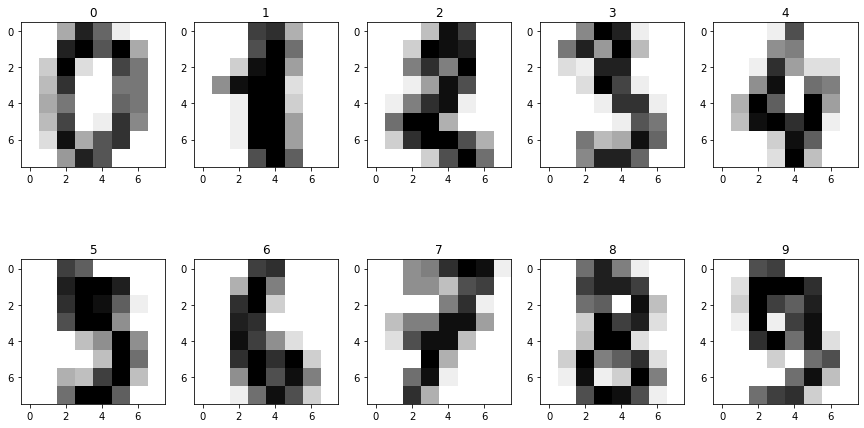

In [4]:
def plot_image(row,subplot):
    '''Extract image data, convert to 8x8 image and plot/label'''
    image = data.iloc[row]
    label = labels.iloc[row]
    
    np_image = image.values
    np_image = np_image.reshape(8,8) # images are 8x8 pixels

    subplot.set_title(label)
    subplot.imshow(np_image, cmap='gray_r') # plot as grayscale 
    
# loop over the first 10 rows and plot the images
fig, axs = plt.subplots(2,5, figsize=(15, 8))
axs = axs.ravel() 
for i in range(0,10,1):
    plot_image(i, axs[i])

A downsampled 8x8 pixel image certainly does not produce a clear picture. Speaking from the perspective of one human, scoring 10/10 would have been a difficult task; the 3 & 5 look very similar as do the 2 & 6. 

# Training and Testing ML models

We will use a number of scikit-learn ML models which all use the same flow; 1. fit/train, 2. predict, 3. test, 4. repeat, 5. Plot/compare. The first step is to therefore create some generic functions to handle these tasks.

In [5]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold

def train(model, features, labels):    
    '''Fit/train a sklearn model'''
    model.fit(features, labels)
    return model

def test(model, features, labels):
    '''Pass a previously fitted/trained model, predict results 
    and perform a simple % accuracy test'''
    # predict
    predictions = model.predict(features)
    # score
    accuracy = sum(predictions == labels)/labels.shape[0]  
    return accuracy

def cross_validate(model, n_splits=4):
    '''Produce an average model accuracy using KFold.
    Test both the train and test features to assess overfit.'''          
    test_accuracies = []    
    kf = KFold(n_splits = n_splits, random_state=2)
    # loop over the n_splits 
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        # train the model
        model = train(model, train_features, train_labels)
        # test the model, with the test labels
        test_accuracy  = test(model, test_features, test_labels)        
        # collect result
        test_accuracies.append(test_accuracy)        
    # return the average for each
    return np.mean(test_accuracies)

def fit_test_all(model, model_kwargs_list=[],title_suffix='',random_state=False,silence=False):
    '''Loop over a set of varying Key words used to fit a model
    then plot kwargs vs the accuracy of the model'''
    
    test_scores = []    
    # loop over kewords
    for model_kwargs in model_kwargs_list:  
        # build a model using current kwargs                
        if random_state:
            model_kwargs['random_state'] = random_state        
        ML = model(**model_kwargs)
        # get current results
        test_score = cross_validate(ML)
        if not silence:
            model_kwargs.pop('random_state', None)
            print('Result: {:.4f} from kwargs:{}'.format(test_score, model_kwargs))
        # collect current results
        test_scores.append(test_score)          

    print('Best Result: {:.4f}'.format(max(test_scores)))
    return test_scores 

def plot_scores(kwargs,knn_scores,kwarg_label,title):
    '''Plot scores vs varying kwargs'''
    plt.plot(kwargs,knn_scores)    
    plt.title(title)
    plt.xlabel(kwarg_label)
    plt.ylabel('Ratio of correct labels')
    plt.show()

Neural Networks are known to produce good results when classifying images. First we will fit other scikit-learn models to gauage a benckmark. 

## The KNeighborsClassifier 
Strictly speaking this is an algorithm, not a model, but it should be expected to perform well if we can expect to have a large enough sample of distinct images - essentially we will find the nearest match to each known image, rather than interpolating a relationship from a set of average images. 

Result: 0.9677 from kwargs:{'n_neighbors': 1}
Result: 0.9616 from kwargs:{'n_neighbors': 2}
Result: 0.9627 from kwargs:{'n_neighbors': 3}
Result: 0.9649 from kwargs:{'n_neighbors': 4}
Result: 0.9622 from kwargs:{'n_neighbors': 5}
Result: 0.9588 from kwargs:{'n_neighbors': 6}
Result: 0.9572 from kwargs:{'n_neighbors': 7}
Result: 0.9572 from kwargs:{'n_neighbors': 8}
Result: 0.9544 from kwargs:{'n_neighbors': 9}
Result: 0.9527 from kwargs:{'n_neighbors': 10}
Best Result: 0.9677


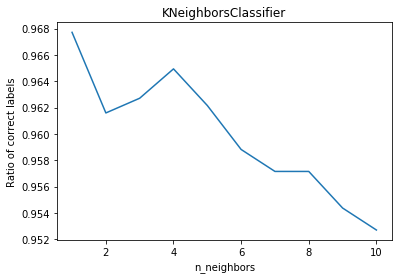

In [6]:
kwargs = list(range(1,11,1))
kwarg_label  = 'n_neighbors'

knn_scores = fit_test_all(KNeighborsClassifier,                           
                          model_kwargs_list= [{kwarg_label:kwarg} for kwarg in kwargs])

# plot all results
plot_scores(kwargs,knn_scores,kwarg_label,'KNeighborsClassifier')

## The LogisticRegression 
LogisticRegression assigns probabilities describing the possible outcomes of a single trial, modeled using a logistic function. This model is well suited for binary data but should extend well to the classification with a choice of 10 image labels. 

Result: 0.9271 from kwargs:{'solver': 'newton-cg'}
Result: 0.9243 from kwargs:{'solver': 'lbfgs'}
Result: 0.9282 from kwargs:{'solver': 'liblinear'}
Best Result: 0.9282


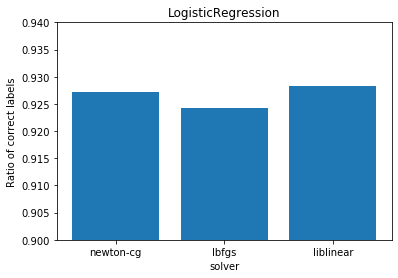

In [7]:
import warnings
warnings.filterwarnings('ignore') # Deprecation Warnings
from sklearn.linear_model import LogisticRegression

kwargs = ["newton-cg", "lbfgs", "liblinear"]
kwarg_label  = 'solver'

lr_scores = fit_test_all(LogisticRegression, 
                          random_state = 2,
                          model_kwargs_list=[{kwarg_label : kwarg} for kwarg in kwargs])

# plot all results - bar chart since the 'solver' (Algorithm) used to optimization problem 
plt.bar(kwargs,lr_scores)    
plt.title('LogisticRegression')
plt.xlabel(kwarg_label)
plt.ylabel('Ratio of correct labels')
plt.ylim((0.9,0.94)) 
plt.show()

There is little difference between the LogisticRegression models. None have performed as well as the KNeighborsClassifier, but all have scored above 9/10 which (based on the first 10 rows) is perhaps still similar to the level human. 

## RandomForestClassifier
A Decision Tree does not seem like it will be the optimal model to classify images; we might expect that each pixel will be treated as a distinct choice within a decision tree. Pixels combine within an image and so have a structure that a decision tree might struggle to properly model. It's therefore likely that even a random forest - which is much less prone to overfitting than a pure decision tree - will struggle not to overfit on the training data and struggle to reproduce the same results on the unseen test data. 

Two of the parameters within the RandomForestClassifier model are very useful in preventing an overfit. These are 1. __min_samples_leaf__; _The minimum number of samples required to split an internal node,_ and 2. __max_depth__; _The maximum depth of the tree._

We will produce scores in 2 dimensions, varying values of __min_samples_leaf__ and __max_depth__. 

Result: 0.5147 from kwargs:{'min_samples_leaf': 1, 'max_depth': 1}
Result: 0.5147 from kwargs:{'min_samples_leaf': 2, 'max_depth': 1}
Result: 0.5147 from kwargs:{'min_samples_leaf': 3, 'max_depth': 1}
Result: 0.5147 from kwargs:{'min_samples_leaf': 4, 'max_depth': 1}
Result: 0.8937 from kwargs:{'min_samples_leaf': 1, 'max_depth': 11}
Result: 0.8943 from kwargs:{'min_samples_leaf': 2, 'max_depth': 11}
Result: 0.8954 from kwargs:{'min_samples_leaf': 3, 'max_depth': 11}
Result: 0.8831 from kwargs:{'min_samples_leaf': 4, 'max_depth': 11}
Result: 0.8931 from kwargs:{'min_samples_leaf': 1, 'max_depth': 21}
Result: 0.8998 from kwargs:{'min_samples_leaf': 2, 'max_depth': 21}
Result: 0.8920 from kwargs:{'min_samples_leaf': 3, 'max_depth': 21}
Result: 0.8915 from kwargs:{'min_samples_leaf': 4, 'max_depth': 21}
Result: 0.8931 from kwargs:{'min_samples_leaf': 1, 'max_depth': 31}
Result: 0.8998 from kwargs:{'min_samples_leaf': 2, 'max_depth': 31}
Result: 0.8920 from kwargs:{'min_samples_leaf': 3, '

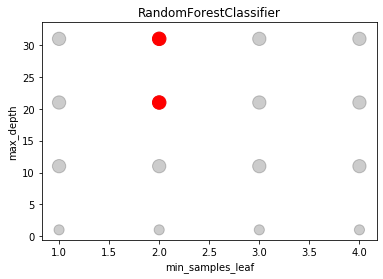

,min_samples_leaf,max_depth,rf_scores
9,2,21,0.899826
13,2,31,0.899826


In [8]:
from sklearn.ensemble import RandomForestClassifier

# create all combinations of min_samples_leaf and max_depth
kwargs = []
max_depths = list(range(1,40,10))
min_leaves = list(range(1,5,1))
for max_depth in max_depths:
    for min_samples_leaf in min_leaves:
        kwargs.append({'min_samples_leaf':min_samples_leaf,'max_depth':max_depth})

# fit the RandomForestClassifier 
rf_scores = fit_test_all(RandomForestClassifier,
                         random_state = 5,
                         model_kwargs_list=kwargs,
                         silence=False)

# use a bubble chart to plot the varying kwargs, bigger bubbles == a better score. 
kwargs_df = pd.DataFrame(kwargs)
kwargs_df['rf_scores'] = rf_scores
bubble_scale = 200 # arbitrary number to make the bubbles bigger

plt.scatter(kwargs_df['min_samples_leaf'], 
            kwargs_df['max_depth'], 
            s=kwargs_df['rf_scores']*bubble_scale, 
            alpha=0.2, c='black')

# find the best result
best_fit = kwargs_df[kwargs_df['rf_scores'] == kwargs_df['rf_scores'].max()] 
# overlay the best fit(s)
plt.scatter(best_fit['min_samples_leaf'], 
            best_fit['max_depth'], 
            s=best_fit['rf_scores']*bubble_scale, 
            alpha=1.0, c='red')

plt.title('RandomForestClassifier')
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.show()
best_fit

The RandomForestClassifier hasn't performed as poorly as expected but it has still failed to get above 9/10 and probably isn't as good as a human at this task. 

To note, varying the random_state yielded differing optimal parameters for the forest. Once the tree becomes deep enough (_max_depth_) there is little improvement. Indeed, using the default parameters achieves a very similar score:

In [9]:
RF = RandomForestClassifier()
cross_validate(RF, n_splits=4)

0.9065120019797079

# Deep Neural Networks (MLPClassifier)
Deep Neural Networks have the ability to learn hierarchical representations. Features within an image don't usually have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. Whereas a Deep Neural Network model will find patterns within the data set and so _understand_ that pixels have relationships to one another.

Deep Neural Networks use model _layers_ and find structure within images. For example, if used on images of faces, the first (hidden) layer might find the edges and specific features of faces. Then additional hidden layers might find higher level facial features like eyes and noses. Each successive layer uses weights from previous layers to try to learn more complex representations.

We will test the MLPClassifier using varying numbers of layers (and neurons). We can expect that increasing the number of layers will improve the scores, but we can expect a limit. At some point using more and more hidden layers will increase the amount of overfitting that happens in the training stage and therefore reduce the predictive power of the overall model. 

Neurons are the basic building block of Neural Networks. A neuron is simply a set of inputs, a set of weights, and an activation function (such as those used in other ML models). The output of the neuron can then be sent as input to the neurons of another layer and the cycle is repeated. 

## A single layer of neurons
We do not expect that using only one layer of neurons will produce the most optimal model/best results. However we can expect that increaing the number of neurons (at least up to a point) will yield better results.

Result: 0.7791 from kwargs:{'hidden_layer_sizes': (8,)}
Result: 0.9199 from kwargs:{'hidden_layer_sizes': (16,)}
Result: 0.9238 from kwargs:{'hidden_layer_sizes': (32,)}
Result: 0.9343 from kwargs:{'hidden_layer_sizes': (64,)}
Result: 0.9444 from kwargs:{'hidden_layer_sizes': (128,)}
Result: 0.9521 from kwargs:{'hidden_layer_sizes': (256,)}
Result: 0.9555 from kwargs:{'hidden_layer_sizes': (512,)}
Best Result: 0.9555


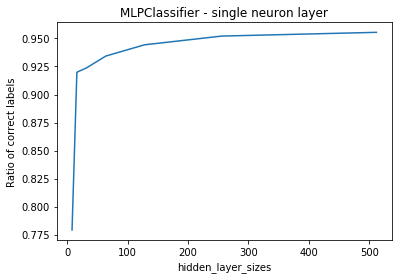

In [10]:
from sklearn.neural_network import MLPClassifier

# configure a series of single-layer neurons: [(n_neurons,)]
nn_one_neurons = [(2**x,) for x in range(3,10)]

kwargs = nn_one_neurons
kwarg_label  = 'hidden_layer_sizes'

ml_scores = fit_test_all(MLPClassifier,
                         random_state = 1,
                         model_kwargs_list=[{kwarg_label : kwarg} for kwarg in kwargs],
                         silence=False
                        )
# plot all results
plot_scores(kwargs,ml_scores,kwarg_label,'MLPClassifier - single neuron layer')

A single layer of neurons has achieved results (almost) as as good as the KNeighborsClassifier (0.9677). There is a significant improvement in the score once the number of neurons is in the double digits. However the improvements are asymptotic such that there is very little improvement in the score when increasing from 256 to 512 neurons. Therefore it is unlikely that the MLPClassifier can beat the KNeighborsClassifier by further increasing the number of neurons.

## Two layers of neurons

Result: 0.9421 from kwargs:{'hidden_layer_sizes': (64, 64)}
Result: 0.9516 from kwargs:{'hidden_layer_sizes': (128, 128)}
Result: 0.9560 from kwargs:{'hidden_layer_sizes': (256, 256)}
Result: 0.9583 from kwargs:{'hidden_layer_sizes': (512, 512)}
Best Result: 0.9583


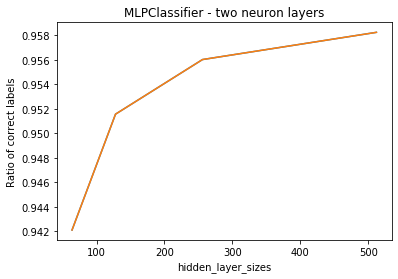

In [11]:
# start from (64,64)
nn_two_neurons = [(2**x,2**x) for x in range(6,10)]

kwargs = nn_two_neurons
kwarg_label  = 'hidden_layer_sizes'

ml_scores = fit_test_all(MLPClassifier,
                         random_state = 1,
                         model_kwargs_list=[{kwarg_label : kwarg} for kwarg in kwargs],
                         silence=False
                        )
# plot all results
plot_scores(kwargs,ml_scores,kwarg_label,'MLPClassifier - two neuron layers')

## Three layers of neurons

Result: 0.9505 from kwargs:{'hidden_layer_sizes': (64, 64, 64)}
Result: 0.9510 from kwargs:{'hidden_layer_sizes': (128, 128, 128)}
Result: 0.9471 from kwargs:{'hidden_layer_sizes': (256, 256, 256)}
Result: 0.9644 from kwargs:{'hidden_layer_sizes': (512, 512, 512)}
Best Result: 0.9644


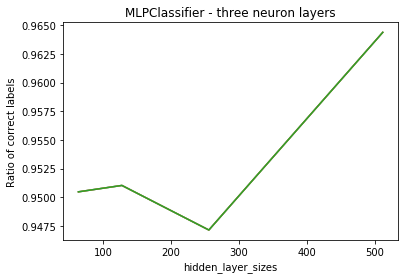

In [12]:
# start from (64,64,64)
nn_three_neurons = [(2**x,2**x,2**x) for x in range(6,10)]

kwargs = nn_three_neurons
kwarg_label  = 'hidden_layer_sizes'

ml_scores = fit_test_all(MLPClassifier,
                         random_state = 1,
                         model_kwargs_list=[{kwarg_label : kwarg} for kwarg in kwargs],
                         silence=False
                        )
# plot all results
plot_scores(kwargs,ml_scores,kwarg_label,'MLPClassifier - three neuron layers')

Increasing the number of layers to three has improved the best score to of the MLPClassifier such that it is roughly equivalent to the KNeighborsClassifier. However the previous asymptotic improvement seen when increasing the number of neurons has broken down. This suggests that the MLPClassifier is overfitting the training data and the limit to this model has been reached. Increasing the number layers further should not be expected to improve the score. 

## Four layers of neurons

Result: 0.9449 from kwargs:{'hidden_layer_sizes': (64, 64, 64, 64)}
Result: 0.9521 from kwargs:{'hidden_layer_sizes': (128, 128, 128, 128)}
Result: 0.9544 from kwargs:{'hidden_layer_sizes': (256, 256, 256, 256)}
Result: 0.9577 from kwargs:{'hidden_layer_sizes': (512, 512, 512, 512)}
Best Result: 0.9577


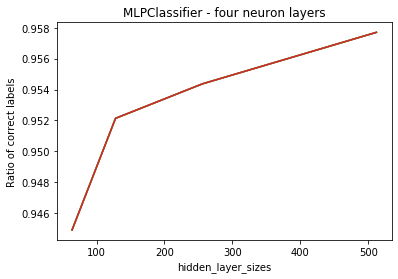

In [13]:
# start from (64,64,64,64)
nn_four_neurons = [(2**x,2**x,2**x,2**x) for x in range(6,10)]

kwargs = nn_four_neurons
kwarg_label  = 'hidden_layer_sizes'

ml_scores = fit_test_all(MLPClassifier,
                         random_state = 1,
                         model_kwargs_list=[{kwarg_label : kwarg} for kwarg in kwargs],
                         silence=False
                        )
# plot all results
plot_scores(kwargs,ml_scores,kwarg_label,'MLPClassifier - four neuron layers')

# Summary
Both the KNeighborsClassifier and MLPClassifier models achieve comparable results, each scoring over 95% accuracy (which is likely as good as or better than this human). 

The KNeighborsClassifier model actually produces marginally better results than the MLPClassifier. It's also very noticable that the KNeighborsClassifier model is much faster than the more complex MLPClassifier models. The question then is, why use a Neural Network over the (much simpler) KNeighborsClassifier model?

The reason is that the KNeighborsClassifier is an algorithm, not a model. Essentially it predicts results by comparing the input features to all known combinations that it has been trained on. For this reason it will not scale to larger data sets as well as the MLPClassifier. Furthermore, the bulk of the processing within the MLPClassifier model occurs when the model is trained. We can therefore expect that the MLPClassifier will produce predictions much faster than the KNeighborsClassifier. 

As a final test, we generate a fitted model each for KNeighborsClassifier and MLPClassifier and then time how long it takes to perform 100 sets of predictions. 

In [14]:
# create a fitted model each for KNeighborsClassifier and MLPClassifier 
# there is no reason to split the data into train/test as overfitting is not a concern
knn = train(KNeighborsClassifier(n_neighbors=1), data, labels)
nn  = train(MLPClassifier(hidden_layer_sizes=(256, 256)), data, labels)

In [15]:
def time_ml_model(fitted_model,no_tests=100):
    '''Time how long it takes to predict the results '''
    import time
    start = time.time()
    for _ in range(no_tests):
        test(fitted_model, data, labels) 
    
    return time.time() - start

In [16]:
knn_time = time_ml_model(knn)
nn_time  = time_ml_model(nn)

print('knn_seconds:  {:.3}\nnn_seconds:   {:.3}\nSpeed Factor: {:.2}'.format(knn_time,nn_time,knn_time/nn_time))

knn_seconds:  7.23
nn_seconds:   0.655
Speed Factor: 1.1e+01


The MLPClassifier is almost an order of magnitude quicker than the KNeighborsClassifier. This is on a data set of less than 2,000 rows and so it should be expected that this overperformance will only increase as the data set grows larger. In a practical use case a model could be trained once and then used to predict 100s of 1000s of results. For this reason - despite their comparable/excellent results - there is really no contest between the two models. 